In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skopt.learning import ExtraTreesRegressor as opt_ETR
from scipy.stats import norm
import random
import warnings
warnings.filterwarnings("ignore")


random.seed(1126)
np.random.seed(1126)
import sklearn
print(sklearn.__version__)

0.23.2


In [2]:
data = pd.read_csv('data/proposed.csv').drop('Unnamed: 0', axis = 1)

#data.loc[:, "Contact time, s"] = np.log(data.loc[:, "Contact time, s"])
feat = data.loc[:, "Li":'Contact time, s']
target = data.loc[:, 'Y(C2), %']
#feat.index = np.arange(30)
#target.index = np.arange(30)

desc = pd.read_csv("data/Descriptors.csv", skiprows=[0], index_col="symbol")
desc.drop(
    [
        "Unnamed: 0",
        "AN",
        "AW",
        "name",
        "period",
        "ionic radius",
        "covalent radius",
        "group",
        "VdW radius",
        "m. p.",
        "b. p.",
        "crystal radius",
        "a x 106 ",
        "atomic radius",
        "Heat capacity ",
        "l",
        "ionization enegy ",
        "electron affinity ",
        "VE",
        "Surface energy ",
    ],
    axis=1,
    inplace=True,
)
desc = desc.fillna(desc.mean())
for i in range(8):
    feat = feat.drop([f"{i+1}_ionization enegy", f"{i+1}_AW", f"{i+1}_atomic radius",f"{i+1}_m. p.",f"{i+1}_b. p.", ], axis =1)
    

comp =feat.loc[:,"Li":"Bi"].columns
prep = feat.loc[:,'Impregnation':'Pechini method'].columns
cond = feat.loc[:, 'Temperature, K':'Contact time, s'].columns
prom = feat.loc[:, 'Promotor_Cl':'Promotor_F'].columns
metal= feat.loc[:, '1_electronegativity':'8_density'].columns
cols = list(prep) + list(cond)
columns = list(comp) + list(prom) + list(prep) + list(cond)
random_state =1126

In [3]:
def opt_function(x, y ,model, desc,random_state =1126):
    """
    各実験ずみの点に対して4回近傍の探索を行い最もEIの高かった組成実験条件を返す
    """
    xx = x.iloc[:,:-2]
    neighbor = pd.DataFrame(index = x.columns)
    for key, row in xx.iterrows():
        count = 0
        nei_cand = []
        #print('ind={0}'.format(key))
        if x.loc[key, 'make_nei'] == True:

            cols =list(prep) + list(cond)


            for _ in range(10):
                row_ch = row.copy()
                
                row_ch = SWED_change(row_ch)

                nei_cand.append(row_ch)
                
            for _ in range(10):
                row_ch = row.copy()
                
                row_ch = experiment_change(row_ch)
                
                nei_cand.append(row_ch)
                
            for _ in range(10):
                row_ch = row.copy()
                
                row_ch = SWED_change(row_ch)
                
                row_ch = experiment_change(row_ch)
                
                nei_cand.append(row_ch)
                   

            nei_cand = pd.DataFrame(nei_cand, index =np.arange(len(nei_cand)))
            temp = comp_times_base(nei_cand.loc[:,comp],desc.loc[comp].T,sort=True,times=True)
            temp = pd.DataFrame(temp)
            temp = temp.iloc[:, :24].fillna(0)
            temp.columns = metal
            nei_cand = pd.concat([nei_cand.loc[:,comp],temp, nei_cand.loc[:, prom], nei_cand.loc[:,prep], nei_cand.loc[:, cond]], axis = 1)
            
            mu, sigma = model.predict(np.array(nei_cand.loc[:,"1_electronegativity":]), return_std=True)
            ind = y.values.argmax()
            cur_max = y.iloc[ind]
            ei = EI(mu, sigma, cur_max)
            ind = np.argmax(ei)
            cand = nei_cand.iloc[ind].copy()
            cand['ei'] = ei[ind]
            if x.loc[key, 'ei'] < cand['ei']:
                cand['make_nei'] = True
                neighbor = pd.concat([neighbor, cand], axis = 1)
            else:
                x.loc[key, 'make_nei'] = False
                neighbor = pd.concat([neighbor, x.loc[key,:]], axis = 1)
                
        else:
            neighbor = pd.concat([neighbor, x.loc[key,:]], axis = 1)
                                                    
    print('-----------')
    
    neighbor = neighbor.T
    neighbor.index = x.index
    return neighbor



def smac(model, init_x, init_y, roen_func, desc, random_state = 1126):
    """
    SMAC　のメインプログラム(鈴木氏作成)
    """
    cur_max = init_y.max()
    sub_x = init_x
    init_x = init_x.loc[:,"1_electronegativity":]
    model.fit(np.array(init_x), np.array(init_y))
    print(model)
    mu, sigma =  posterior(np.array(init_x), np.array(init_x), init_y, model)
    ei =  EI(mu, sigma, init_y.max())
    ei = pd.Series(ei, index = init_x.index, name = 'ei')
    make_nei =pd.Series(True, index=init_x.index, name='make_nei')
    next_x = pd.concat([sub_x, ei, make_nei], axis =1)
    while next_x['make_nei'].sum() != 0:
        next_x = roen_func(next_x, init_y, model, desc)
        print(next_x['make_nei'].sum())
        
    cand = next_x
        
    return cand

def posterior(x, p_x, p_y, model):
    """
    EIを計算する上でのμならびにσの計算(鈴木氏作成)
    """
    if len(p_x.shape) == 1:
        model.fit(p_x.reshape(-1, 1), p_y)
        mu, sigma = model.predict(x.reshape(-1, 1), return_std = True)
    else:
        model.fit(p_x, p_y)
        mu, sigma = model.predict(x, return_std = True)
    ind = np.where(sigma == 0)
    sigma[ind] = 1e-5
    return mu, sigma

def EI(mu, sigma, cur_max):
    """
    EIの計算(鈴木氏作成)
    """
    Z = (mu - cur_max)/ sigma
    ei = (mu - cur_max) * norm.cdf(Z) + sigma*norm.pdf(Z)
    return ei


def comp_times_base(comp, base, sort=False, times=True, attention=False):
    """
    elementからaddtional descriptorに変更するプログラム(鈴木氏作成)
    """
    count = 0
    for key, rows in comp.iterrows():
        
        stack = np.vstack((rows, base))
        if times == True:
            time = np.array(base) * np.array(rows)
            stack = np.vstack((rows, time))

        if sort == True:
            stack = pd.DataFrame(stack).sort_values(
                [0], ascending=False, axis=1)

        stack = pd.DataFrame(stack).iloc[1:, :]
        stack = np.array(stack)

        if count == 0:
            if attention:
                res = np.sum(stack, axis=1)
            else:
                res = np.array(stack.T.flatten())

            count += 1
        else:
            if attention:
                res = np.vstack((res, np.sum(stack, axis=1)))
            else:
                res = np.vstack((res, np.array(stack.T.flatten())))

            count += 1
    return res

def SWED_change(row_ch):
    row_ch[comp] = 0

    for i in range(8):
        #i-1回目の処理のデータを保存
        row_sub = row_ch
        x_ch =data

        #大きい方からchange_f番目の元素に紐ずくaddtional descriptorを一括での局所的探索
        change_col= list([f"{i+1}_electronegativity", f"{i+1}_delta_fus H",f"{i+1}_density"])
        if (row_ch[change_col] >= x_ch[change_col].min()).all():
            a = row_ch[change_col] - x_ch[change_col].min()
        else:
            a = x_ch[change_col].min()- x_ch[change_col].min()
        b = x_ch[change_col].max() - x_ch[change_col].min()
        v = a/b

        v = np.minimum(v, 1.0)


        p = np.array([-1])
        count =0
        while (p <0).any() | (p>1).any():
            p = random.normalvariate(v, 0.2)
            count += 1
            if (count % 100) == 0:
                print(f"cycle error {count}")

        p = p * b + x_ch[change_col].min()
        row_ch[change_col] = p
        p = np.array(p)

        #alpha = x1_x0/x1_2#２次関数の軸の位置
        alpha = desc.apply(lambda u: np.dot(u, p)/np.dot(u, u), axis = 1)
        #εの値が小さい元素名を返す
        epsilon = desc.mul(alpha, axis=0).apply(lambda u: np.dot(u-p, u-p), axis=1).sort_values().index


        for i in range(0, len(epsilon)):
            #軸が100以下をみたし、　組成元素が0ではない元素に変換する
            if (alpha[epsilon[i]] < 100) & (row_ch[epsilon[i]] == 0):
                row_ch[epsilon[i]] = alpha[epsilon[i]]
                break

        #組成の合計が100を超えると処理を抜ける        
        if row_ch[comp].sum() >= 100:
            break

    # 100によりちかい組成を選択肢、標準化
    if  abs(100 -row_ch[comp].sum()) > abs(100-row_sub[comp].sum()):
        row_ch[comp] =  (row_sub[comp] * 100) / row_sub[comp].sum()

    else:
        row_ch[comp] =  (row_ch[comp] * 100) / row_ch[comp].sum()
    
    return row_ch

def experiment_change(row_ch):
    cols =list(prep) + list(cond)
    x_ch = data
    
    change_f = random.choice(cols)
    
    if change_f in cond:
        a = np.array(row_ch[change_f]) - x_ch[change_f].min()
        b = x_ch[change_f].max() - x_ch[change_f].min()
        v = a / b
        p = -1
        while (p < 0) | (p > 1):
            p = random.normalvariate(v, 0.2)

        p = p * b + x_ch[change_f].min()
        row_ch[change_f] = p

    elif change_f in prep:
        row_ch[change_f] = 1
        ind = set(prep) - {change_f}
        row_ch[ind] = 0
        
    return row_ch

    

## SMAC

In [6]:
%%time
 model = opt_ETR(n_estimators = 500, random_state = 1126, n_jobs = -1)
cand = smac(model, feat, target,opt_function, desc)


ExtraTreesRegressor(n_estimators=500, n_jobs=-1, random_state=1126)
cycle error 100
cycle error 200
cycle error 300
cycle error 400
cycle error 100
cycle error 200
cycle error 100
cycle error 200
cycle error 100
cycle error 100
cycle error 200
cycle error 300
cycle error 400
cycle error 100
cycle error 200
cycle error 300
cycle error 400
cycle error 500
cycle error 600
cycle error 100
cycle error 200
cycle error 300
cycle error 400
cycle error 500
cycle error 600
cycle error 100
cycle error 200
cycle error 300
cycle error 400
cycle error 500
cycle error 600
cycle error 100
cycle error 200
cycle error 300
cycle error 100
cycle error 200
cycle error 300
cycle error 400
cycle error 100
cycle error 100
cycle error 100
cycle error 100
cycle error 200
cycle error 100
cycle error 200
cycle error 300
cycle error 400
cycle error 100
cycle error 200
cycle error 300
cycle error 400
cycle error 500
cycle error 100
cycle error 200
cycle error 100
cycle error 200
cycle error 100
cycle error 200
cycl

## 以下クラスタリング

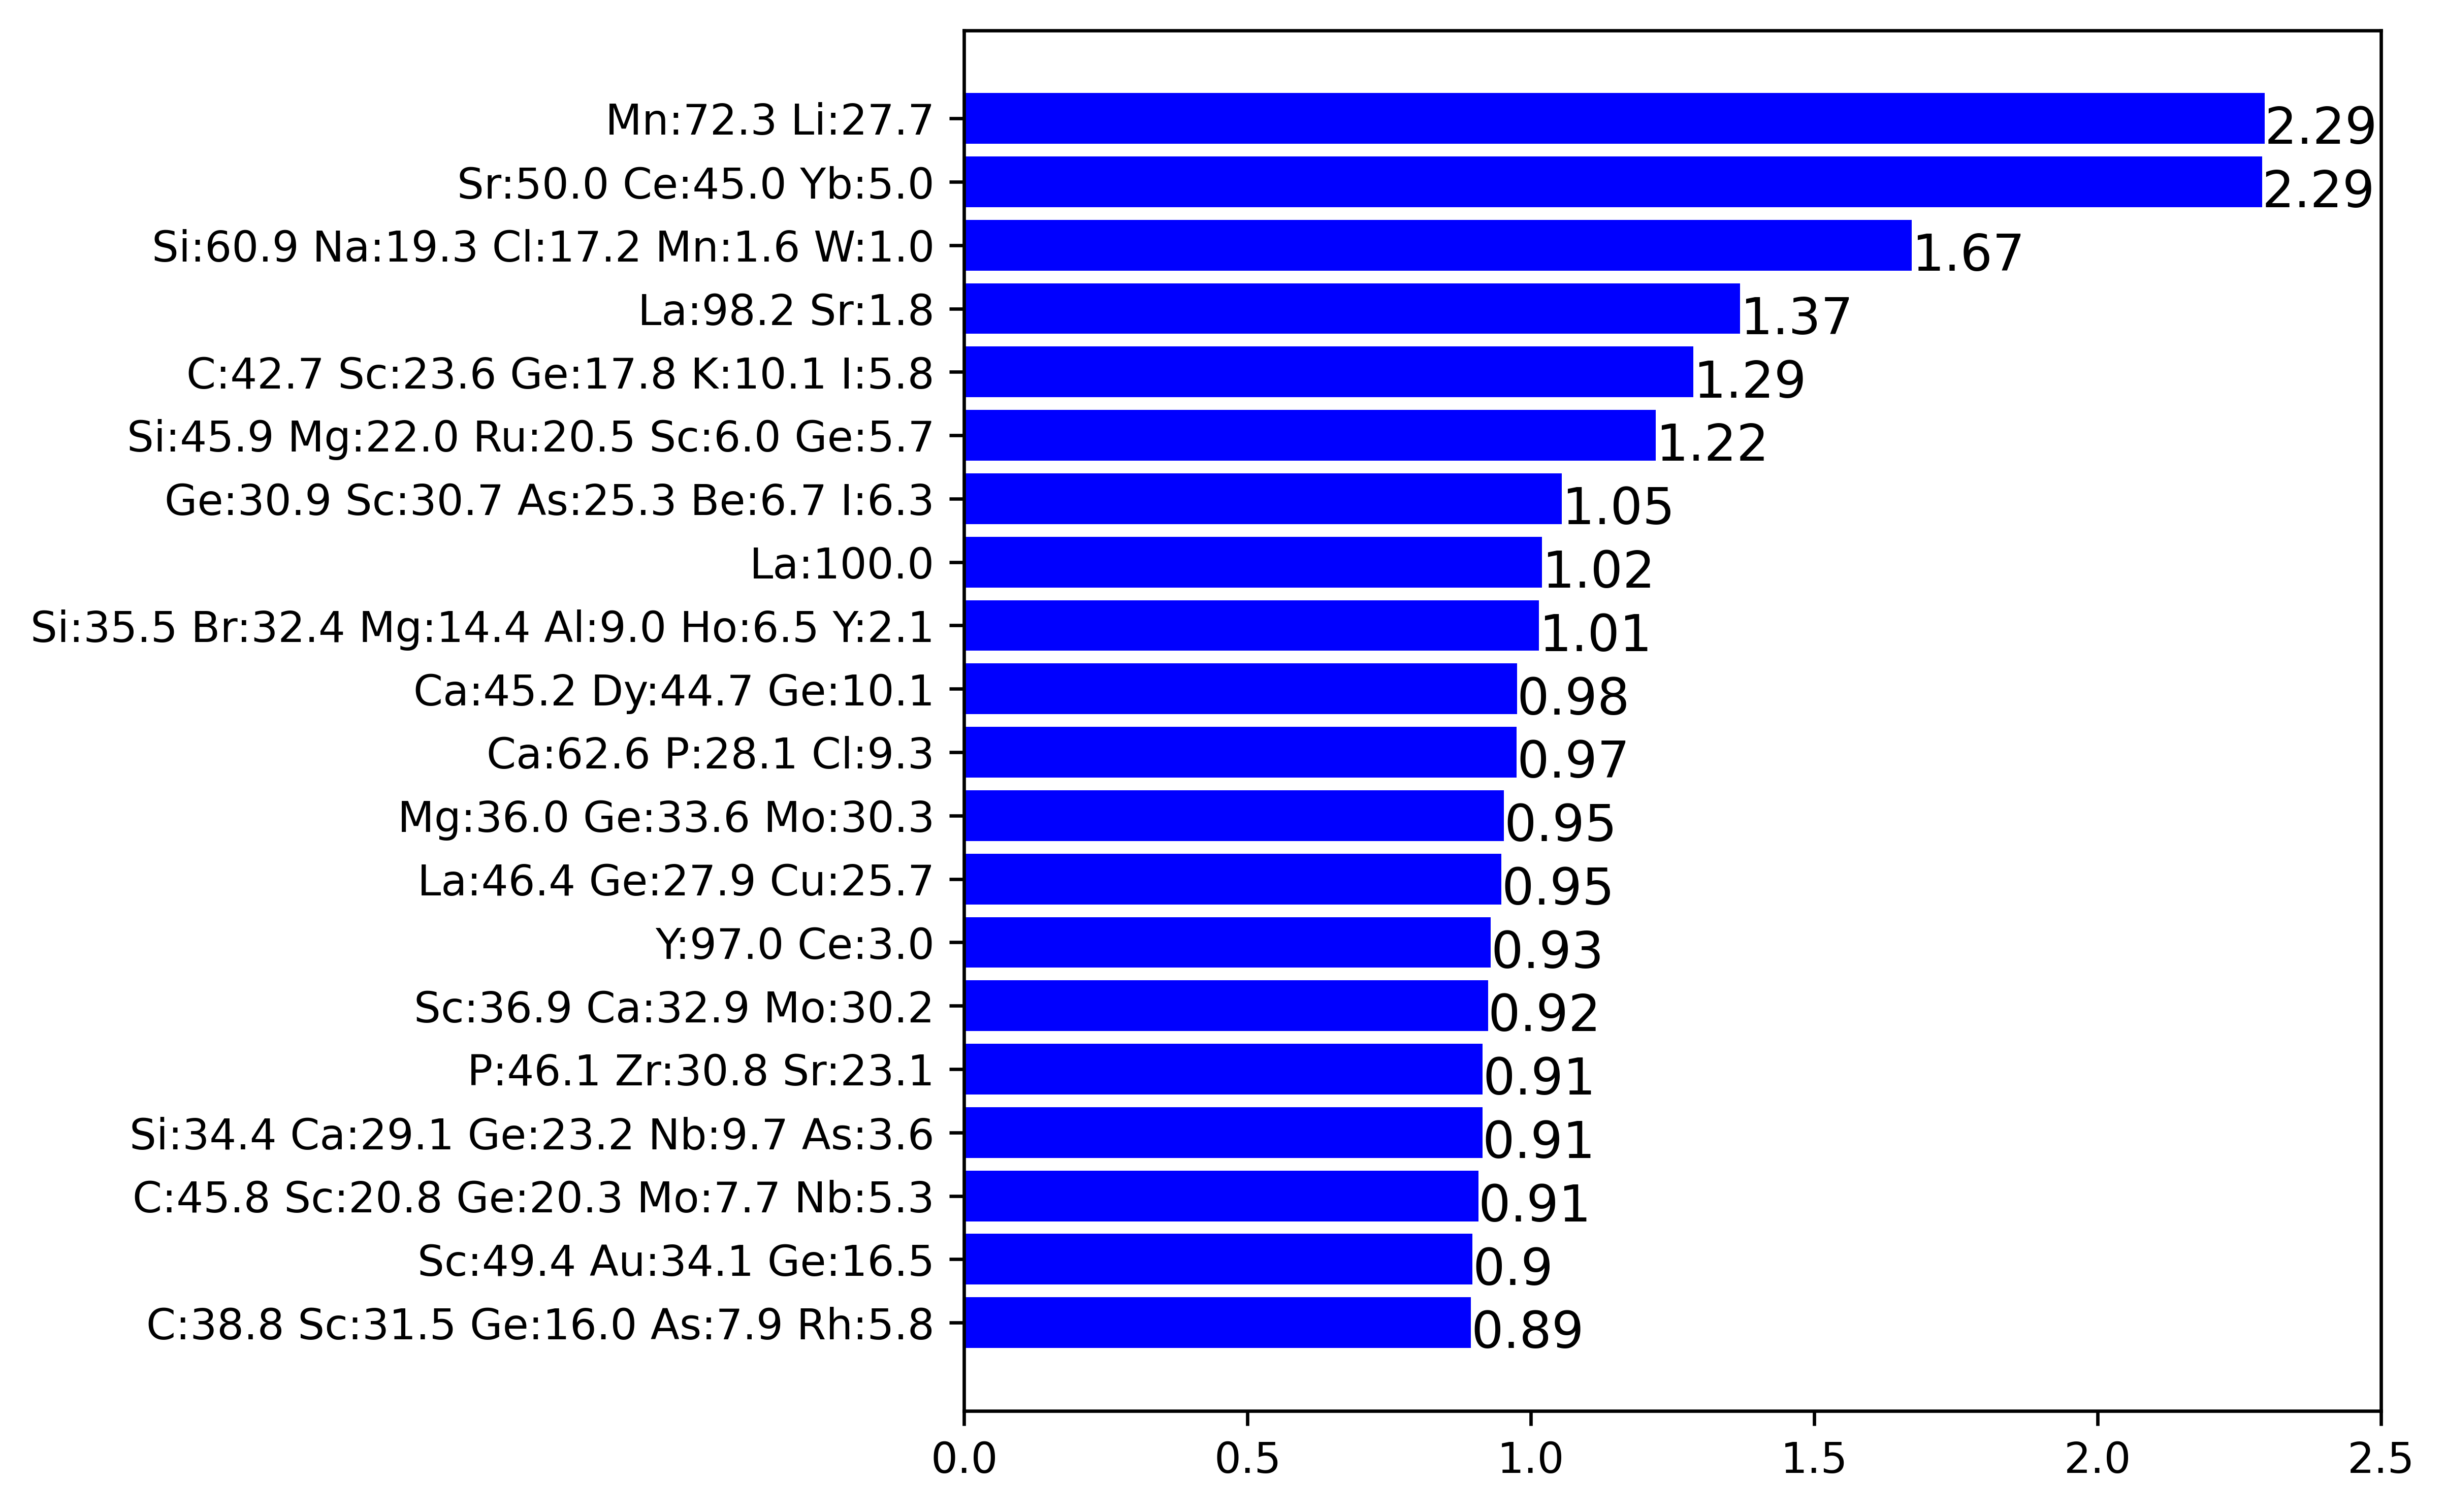

In [11]:
#feat.loc[:,'Contact time, s'] = np.log10(feat.loc[:,'Contact time, s'])
from sklearn.cluster import KMeans
feat = feat.loc[:,"1_electronegativity":"Contact time, s"]
model = opt_ETR(n_estimators = 500, n_jobs = -1)
k = KMeans(n_clusters=100, random_state=1126)
cluster = k.fit_predict(cand.iloc[:,:-1])
cluster = pd.Series(cluster, index=cand.index, name='cluster')
cand = pd.concat([cand,cluster], axis=1)
model.fit(feat, target)
pred_y = model.predict(cand.loc[:,"1_electronegativity":"Contact time, s"])
pred_y = pd.Series(pred_y, index = cand.index, name = 'pred_y')
cand = pd.concat([cand,pred_y], axis = 1)
#choose point which has most better ei value in each cluster
clus_high = cand.sort_values(by=['cluster','ei']).drop_duplicates(subset=['cluster'],keep='last')
clus_high = clus_high.sort_values(by='ei', ascending=False)

hogege = []
for key,row in clus_high.loc [:,comp].iterrows():
    temp = [str(i)+':'+str(round(v,1)) for i,v in row[row>0].sort_values(ascending=False).iteritems()]
    hogege.append(temp)
    
hogege = [' '.join(x) for x in hogege]

w = 0.4
hoge = clus_high.iloc[:20]
x = np.arange(hoge.shape[0])
pred_y = list(clus_high['pred_y'])
    
                
extra = []
for y in x:
    extra.append(y)
    
ytick = []
for n in range(20):
    ytick.append(hogege[n])
    
plt.figure(figsize=(6,6), dpi=600)
plt.barh(x,hoge['ei'][::-1],label='EI', color = 'blue')
for n,i in enumerate(x[::-1]):
    plt.text(clus_high['ei'].iloc[n],i-0.4,str(round(clus_high['ei'].iloc[n],2)),fontsize=12)
    
temp =clus_high.loc[:,"Temperature, K":"ei"]
temp.index = hogege

plt.xlim([0,2.5])
plt.yticks(x[::-1],ytick)
#temp =clus_high.loc[:,"Temperature, K":"ei"]
#temp.index = hogege
#temp.to_csv("Table_3.csv")
plt.savefig('out/ETR.png', dpi = 600, bbox_inches = 'tight')

In [8]:
#cand.loc[:, "Contact time, s"] = np.exp(cand.loc[:, "Contact time, s"].astype("float"))
cand.to_csv("out/cand.csv")

In [9]:
cand.sort_values("ei", ascending = False)

,Li,Be,B,C,N,F,Na,Mg,Al,Si,...,IJP-A synthesis,Pechini method,"Temperature, K",p(CH4)/p(O2),"p total, bar","Contact time, s",ei,make_nei,cluster,pred_y
534,27.7,0,0,0,0,0,0,0,0,0,...,0,0,1023,1.66667,1.013,1.2,2.29426,False,80,25.692759
256,0,0,0,0,0,0,0,0,0,0,...,0,0,1023,1.98507,1.013,0.79,2.28985,False,79,25.881299
508,0,0,0,0,0,0,0,0,0,0,...,0,0,1023,1.98529,1.013,0.791062,1.98608,False,79,26.436484
532,33.3,0,0,0,0,0,0,33.3,0,0,...,0,0,1003,1.5,1.013,0.78,1.69825,False,79,24.575261
3098,0,0,0,0,0,0,19.2506,0,0,60.9063,...,0,0,1023,1.6,1.01,0.0181941,1.67171,False,41,25.549264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614,15.0215,0,0,0,0,0,0,80.1946,0,0,...,0,0,873.15,4,1,1.5,0.0003517,False,65,8.071031
115,0,0,0,8.27453,0,0,0,0,0,0,...,0,0,1013,8.96552,1.013,0.38,0.000279208,False,25,8.295053
114,0,0,0,0,0,0,0,0,0,0,...,0,0,1013,8.96552,1.013,0.14,0.000184872,False,44,8.466104
15,0,0,0,0,0,0,0,0,45.4142,0,...,0,0,1023,9.80769,1.013,4.3,0.000136424,False,79,8.585938


In [10]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib as cm

from sklearn.inspection import partial_dependence

In [11]:
data = pd.read_csv('data/conventional.csv').drop('Unnamed: 0', axis = 1)
idx =  (data.loc[:, "W"] >0) & (data.loc[:, "Mn"] >0)
feat = data.loc[idx, "Li":'Contact time, s']
target = data.loc[idx, 'Y(C2), %']

want = pd.DataFrame(columns = feat.columns)
x = np.arange(0, 10, 0.05)
y = np.arange(0, 10, 0.05)
x, y = np.meshgrid(x, y)
x = x.flatten().T
y = y.flatten().T
want.loc[:,'Mn'] = x
want.loc[:,'W'] = y
want.loc[:, 'Na'] = 2*y
want.loc[:, 'Si'] = 100 -x - 3*y
want.loc[:, 'Impregnation'] = 1
want.loc[:, 'Temperature, K'] = 1073.15
want.loc[:, 'p(CH4)/p(O2)'] = 4
want.loc[:, 'Contact time, s'] = 0.1
want.loc[:, 'p total, bar'] = 1
want = want.fillna(0)

FileNotFoundError: [Errno 2] No such file or directory: 'out/pdp/ei_Mn_W.csv'

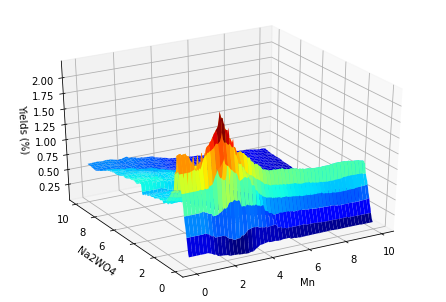

In [12]:
model = opt_ETR(n_estimators = 500, random_state = 1126)
model.fit(feat, target)
want_pred, sigma = model.predict(want, return_std = True)
ind = want_pred.argmax()
cur_max = want_pred[ind]
want_pred = pd.DataFrame(want_pred)
ei_ = pd.DataFrame(EI(pd.DataFrame(want_pred), pd.DataFrame(sigma), cur_max))

fig = plt.figure()
ax = Axes3D(fig, azim = 240)
ei = np.array(ei_).reshape(200,200)
x = np.arange(0, 10, 0.05)
y = np.arange(0, 10, 0.05)
x, y = np.meshgrid(y, x)
ax.set_xlabel('Mn')
ax.set_ylabel('Na2WO4')
ax.set_zlabel('Yields (%)')
surf = ax.plot_surface(x, y, ei, cmap = plt.cm.jet, linewidth = 240)
np.savetxt("out/pdp/ei_Mn_W.csv", ei, delimiter=",")
np.savetxt('out/pdp/ei_Mn.csv', x, delimiter =',')
np.savetxt("out/pdp/ei_W.csv", y, delimiter=",")

plt.colorbar(surf)

In [ ]:
ei_.loc[:, "x"] = x.flatten()
ei_.loc[:, "y"] = y.flatten()
ei_

In [ ]:
idx =ei_.iloc[:, 0] > 2.0
ei_ = ei_[idx]

In [ ]:
ei_.describe()

In [ ]:
idx = (ei_ >1 )


In [ ]:
cand = cand.iloc[:, :-2]
cand

In [ ]:
cand.to_csv("out/cand.csv")

In [10]:
cand = pd.read_csv('out/cand.csv').iloc[:, :-2]

In [9]:
cand = pd.read_csv("out/clus_high.csv")
cand

,Unnamed: 0,0,0.1,0.2,0.3,1,2,3,0.4
0,0,Mn:72.3 Li:27.7,Solid-phase technique,Promotor_B,1023.000000,1.666667,1.013000,1.200000,2.294258
1,1,Sr:50.0 Ce:45.0 Yb:5.0,Solid-phase technique,NaN,1023.000000,1.985075,1.013000,0.790000,2.289853
2,2,Si:60.9 Na:19.3 Cl:17.2 Mn:1.6 W:1.0,Hydrothermal treatment,NaN,1023.000000,1.600000,1.010000,0.018194,1.671710
3,3,Mn:80.0 Li:20.0,Solid-phase technique,Promotor_Cl,1023.000000,1.961538,1.000000,0.600000,1.370826
4,4,Mg:82.8 Li:17.2,Solid-phase technique,NaN,1043.000000,3.000000,1.013000,5.500000,1.309948
...,...,...,...,...,...,...,...,...,...
75,75,Hf:82.0 Ge:11.3 Si:3.3 As:1.8 Co:1.0 Sc:0.5 W:...,Physical mixing,NaN,1013.150000,0.660755,4.660580,2.045455,0.403752
76,76,Si:52.5 C:40.3 Ge:7.2,Ceramic method,NaN,1020.685311,1.874389,1.000000,0.010608,0.372260
77,77,Ir:50.8 Si:18.0 Ge:14.4 S:8.6 Ni:7.0 Cd:1.0 Mo...,Physical mixing,NaN,1044.516020,1.971901,2.105104,0.038402,0.327868
78,78,C:64.8 Mo:13.8 Nb:10.2 Y:8.0 Ge:3.2,Physical mixing,NaN,973.150000,1.190308,2.408460,1.839183,0.282645


In [ ]:
cand.loc[:, ]